# Alpha Missense Project

In this project, we hope to analyze Alpha Missense and determine if it is accurate for cancer driver genes and pathways. [AlphaMissene](https://www.science.org/doi/10.1126/science.adg7492) was based on AlphaFold and extended their original model to predict pathogenicity of missense mutations across the human proteome. However, the AlphaMissense paper only barely touched on its possible applications in cancer, so it is still unclear how Alpha Missense performs with cancer data. An accurate pathogenicity predictor could be used to identify novel somatic driver mutations or predict patient outcomes.  


##Setting Up

Firstly, we need to download the Alpha Missense file of all mutations and their predicted pathogenicities and format this to be used with CPTAC data.

### Imports

To get started, we will install the cptac package for grabbing mutation and clinical data, and the biomart package for matching up transcripts to genes.

In [ ]:
!pip install cptac==1.1.0
!pip install biomart

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gtfparse: filename=gtfparse-2.0.1-py3-none-any.whl size=15284 sha256=348920306e7a7d1e12fa5d86bed590bd1108c1ea0c83335cbbc8db5651a5c569
  Stored in directory: /root/.cache/pip/wheels/a0/eb/0e/17d7a46bd8267780846b1f2e3ee96ad935663b70c593301983
Successfully built gtfparse


Importing required modules

In [ ]:
#packages that contain cancer tables we need.
import cptac
import biomart
#used for recieving information from Uniprot later on
import re
import json
import requests
import string
#stats and graphing packages
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
import scipy.stats as stats
import pandas as pd
import numpy as np
import statistics
import seaborn as sns

###Getting the Alpha Missense gene level predictions (for all human genes)

Alpha Missense contains information for multiple human genome versions. HG38 is the version used by CPTAC, so that is the version we will use here. We will start by working with a table of average missense pathogenicities by gene, and later move on to a table of pathogenicities for each possible missense mutation.

In [ ]:
#Downlading alpha missense gene pathogenicities table for HG38

!wget https://storage.googleapis.com/dm_alphamissense/AlphaMissense_gene_hg38.tsv.gz
!gunzip '/content/AlphaMissense_gene_hg38.tsv.gz'

--2023-12-17 21:22:07--  https://storage.googleapis.com/dm_alphamissense/AlphaMissense_gene_hg38.tsv.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.207, 74.125.203.207, 64.233.187.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253636 (248K) [application/x-gzip]
Saving to: ‘AlphaMissense_gene_hg38.tsv.gz’

AlphaMissense_gene_ 100%[===================>] 247.69K   504KB/s    in 0.5s    

2023-12-17 21:22:08 (504 KB/s) - ‘AlphaMissense_gene_hg38.tsv.gz’ saved [253636/253636]



In [ ]:
#Read in the table into pandas, and drop the header lines with skiprows.
gene_pathogenicity_hg38 = pd.read_csv('AlphaMissense_gene_hg38.tsv', skiprows=3, sep='\t')

gene_pathogenicity_hg38
#Notice how this has transcript IDs. We need to map these to gene names to work with CPTAC

,transcript_id,mean_am_pathogenicity
0,ENST00000000233.10,0.742270
1,ENST00000000412.8,0.378343
2,ENST00000001008.6,0.422290
3,ENST00000001146.6,0.466606
4,ENST00000002125.9,0.351480
...,...,...
19228,ENST00000673386.1,0.209559
19229,ENST00000673439.1,0.349771
19230,ENST00000673466.1,0.669078
19231,ENST00000673477.1,0.287994


###Mapping Transcript IDs to Gene Names

This table uses gene names instead of transcript names, and the CPTAC dataset uses HUGO gene names instead of ensembl. Using the biomart package, we can make a table of HUGO gene names to ensembl transcript ids.

In [ ]:
def get_ensembl_mappings():
    # Set up connection to server

    #Try whichever server is up. If this doesn't work, check connection or other servers.

    try:
      server = biomart.BiomartServer('http://www.ensembl.org/biomart')
    except:
      print("Main server failed. Trying US west.")
      try:
        server = biomart.BiomartServer("http://uswest.ensembl.org/biomart")
      except:
        print("US west server failed. Trying US east.")
        try:
          server = biomart.BiomartServer('http://useast.ensembl.org/biomart')
        except:
          print("None of the server mirrors worked.")
          exit()

    mart = server.datasets["hsapiens_gene_ensembl"]

    # List the types of data we want
    attributes = ['ensembl_transcript_id', 'hgnc_symbol',
                  'ensembl_gene_id', 'ensembl_peptide_id']

    # Get the mapping between the attributes
    response = mart.search({'attributes': attributes})
    data = response.raw.data.decode('ascii')

    ensembl_to_genesymbol = {}
    # Store the data in a dict
    for line in data.splitlines():
        line = line.split('\t')
        # The entries are in the same order as in the `attributes` variable
        transcript_id = line[0]
        gene_symbol = line[1]
        ensembl_gene = line[2]
        ensembl_peptide = line[3]

        # Some of the fields are empty. This keeps useless entries from going in the dict
        if len(gene_symbol) > 0:
          ensembl_to_genesymbol[transcript_id] = gene_symbol
          ensembl_to_genesymbol[ensembl_gene] = gene_symbol
          ensembl_to_genesymbol[ensembl_peptide] = gene_symbol

    #also removes a useless entry. Easier than a bunch of if statments
    del ensembl_to_genesymbol['']

    return ensembl_to_genesymbol

In [ ]:
ensembl_mappings = get_ensembl_mappings()
ensembl_mappings

cptac warning: Your version of cptac (1.1.0) is out-of-date. Latest is 1.5.10. Please run 'pip install --upgrade cptac' to update it. (/usr/lib/python3.10/threading.py, line 953)


{'ENST00000387314': 'MT-TF',
 'ENSG00000210049': 'MT-TF',
 'ENST00000389680': 'MT-RNR1',
 'ENSG00000211459': 'MT-RNR1',
 'ENST00000387342': 'MT-TV',
 'ENSG00000210077': 'MT-TV',
 'ENST00000387347': 'MT-RNR2',
 'ENSG00000210082': 'MT-RNR2',
 'ENST00000386347': 'MT-TL1',
 'ENSG00000209082': 'MT-TL1',
 'ENST00000361390': 'MT-ND1',
 'ENSG00000198888': 'MT-ND1',
 'ENSP00000354687': 'MT-ND1',
 'ENST00000387365': 'MT-TI',
 'ENSG00000210100': 'MT-TI',
 'ENST00000387372': 'MT-TQ',
 'ENSG00000210107': 'MT-TQ',
 'ENST00000387377': 'MT-TM',
 'ENSG00000210112': 'MT-TM',
 'ENST00000361453': 'MT-ND2',
 'ENSG00000198763': 'MT-ND2',
 'ENSP00000355046': 'MT-ND2',
 'ENST00000387382': 'MT-TW',
 'ENSG00000210117': 'MT-TW',
 'ENST00000387392': 'MT-TA',
 'ENSG00000210127': 'MT-TA',
 'ENST00000387400': 'MT-TN',
 'ENSG00000210135': 'MT-TN',
 'ENST00000387405': 'MT-TC',
 'ENSG00000210140': 'MT-TC',
 'ENST00000387409': 'MT-TY',
 'ENSG00000210144': 'MT-TY',
 'ENST00000361624': 'MT-CO1',
 'ENSG00000198804': 'MT-CO

Now that we have the dictionary loaded in, we will use it to generate another column in the transcript/pathogenecity table

In [ ]:
def transcript_to_gene(row):
  transcript = row["transcript_id"]
  transcript_parsed = re.sub(r"\.\d+", "", transcript)

  if transcript_parsed in ensembl_mappings:
    gene= ensembl_mappings[transcript_parsed]
    if gene!="":
      return gene
    else:
      return 0
  else:
    return 0


In [ ]:
gene_pathogenicity_hg38["Gene"]= gene_pathogenicity_hg38.apply(transcript_to_gene, axis=1)

In [ ]:
l = gene_pathogenicity_hg38["Gene"].value_counts().tolist()

#Making sure we have no duplicate gene/transcript/pathogenicity mappings
m = sum([x > 1 for x in l])
print("Duplicates: " + str(m) + "\n")
print(gene_pathogenicity_hg38["Gene"].value_counts())

Duplicates: 56

0             651
CR1             3
PALM2AKAP2      3
SCN8A           2
SMIM43          2
             ... 
FJX1            1
TSPYL6          1
HADHB           1
NOS1            1
HTN3            1
Name: Gene, Length: 18526, dtype: int64


###Getting Alpha Missense codon level predictions

This file is much larger than the gene level table, and we did a lot of pruning on it. The file was generated in a different Google Collab notebook (https://colab.research.google.com/drive/1ez3j__HzhWuym7BDwDtVmrOvYDxysb6Z) and stored on box.

In [ ]:
#Pull cleaned dataframe from box
!wget https://byu.box.com/shared/static/4yys75nwzy3kpi3d7xifpiih7meofwmz.csv

--2023-12-17 21:23:22--  https://byu.box.com/shared/static/4yys75nwzy3kpi3d7xifpiih7meofwmz.csv
Resolving byu.box.com (byu.box.com)... 74.112.186.144
Connecting to byu.box.com (byu.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/4yys75nwzy3kpi3d7xifpiih7meofwmz.csv [following]
--2023-12-17 21:23:22--  https://byu.box.com/public/static/4yys75nwzy3kpi3d7xifpiih7meofwmz.csv
Reusing existing connection to byu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://byu.app.box.com/public/static/4yys75nwzy3kpi3d7xifpiih7meofwmz.csv [following]
--2023-12-17 21:23:22--  https://byu.app.box.com/public/static/4yys75nwzy3kpi3d7xifpiih7meofwmz.csv
Resolving byu.app.box.com (byu.app.box.com)... 74.112.186.144
Connecting to byu.app.box.com (byu.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b

In [ ]:
hg38 = pd.read_csv("/content/4yys75nwzy3kpi3d7xifpiih7meofwmz.csv", index_col="combined_column")
hg38

,am_pathogenicity
combined_column,
A1BG_A118D,0.2091
A1BG_A118G,0.1328
A1BG_A118P,0.0468
A1BG_A118S,0.0929
A1BG_A118T,0.0935
...,...
ZZZ3_Y898D,0.9944
ZZZ3_Y898F,0.3655
ZZZ3_Y898H,0.9837


In [ ]:
hg38["am_pathogenicity"] = hg38["am_pathogenicity"].astype("float")

##Pathogenicty by Gene (Endometrial and Breast)

Our initial hypothesis was that genes that were more pathogenic (from the gene level AlphaMissense dataset) would be more prevalent in cancer. We checked this on Endometrial and Breast cancer in CPTAC as they had some of the most somatic hypermutations.

In [ ]:
cptac.download('endometrial')
en = cptac.Endometrial()

In [ ]:
en_som = en.get_somatic_mutation()
en_miss = en_som[en_som['Mutation']=="Missense_Mutation"]
en_miss["Patient_ID"] = en_miss.index
en_miss

<ipython-input-14-a115a24f4965>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_miss["Patient_ID"] = en_miss.index


Name,Gene,Mutation,Location,Patient_ID
Patient_ID,,,,
C3L-00006,AAK1,Missense_Mutation,p.A592V,C3L-00006
C3L-00006,AANAT,Missense_Mutation,p.R176W,C3L-00006
C3L-00006,ABCC4,Missense_Mutation,p.R691H,C3L-00006
C3L-00006,ABL1,Missense_Mutation,p.G273R,C3L-00006
C3L-00006,AC004381.6,Missense_Mutation,p.R620H,C3L-00006
...,...,...,...,...
C3N-01825,TET1,Missense_Mutation,p.D1666H,C3N-01825
C3N-01825,TGFB3,Missense_Mutation,p.E240K,C3N-01825
C3N-01825,TP53,Missense_Mutation,p.R175H,C3N-01825


In [ ]:
#Add pathogenicity into the endometrial dataset.
en_miss_with_path = en_miss.merge(gene_pathogenicity_hg38,how='inner')
en_miss_with_path.sort_values(by='mean_am_pathogenicity', ascending=False)
#Group by Gene and pathogenicity to get a count of how many people have a mutation in a gene.
en_miss_with_path_counts= en_miss_with_path.groupby(["Gene","mean_am_pathogenicity"]).agg(Gene_Count=('Gene', 'count')).reset_index()
en_miss_with_path_counts.sort_values(by= "Gene_Count", ascending = False)
en_miss_with_path.head(500)

,Gene,Mutation,Location,Patient_ID,transcript_id,mean_am_pathogenicity
0,AAK1,Missense_Mutation,p.A592V,C3L-00006,ENST00000409085.9,0.496585
1,AAK1,Missense_Mutation,p.T354I,C3L-00586,ENST00000409085.9,0.496585
2,AAK1,Missense_Mutation,p.K74N,C3N-00151,ENST00000409085.9,0.496585
3,AANAT,Missense_Mutation,p.R176W,C3L-00006,ENST00000392492.7,0.281364
4,ABCC4,Missense_Mutation,p.R691H,C3L-00006,ENST00000645237.2,0.433087
...,...,...,...,...,...,...
495,CLASRP,Missense_Mutation,p.R660Q,C3N-00151,ENST00000221455.8,0.545647
496,CLEC10A,Missense_Mutation,p.C39Y,C3L-00006,ENST00000254868.8,0.283098
497,CLIP3,Missense_Mutation,p.R86C,C3L-00006,ENST00000593074.5,0.546005
498,CLIP3,Missense_Mutation,p.P174T,C3N-00328,ENST00000593074.5,0.546005


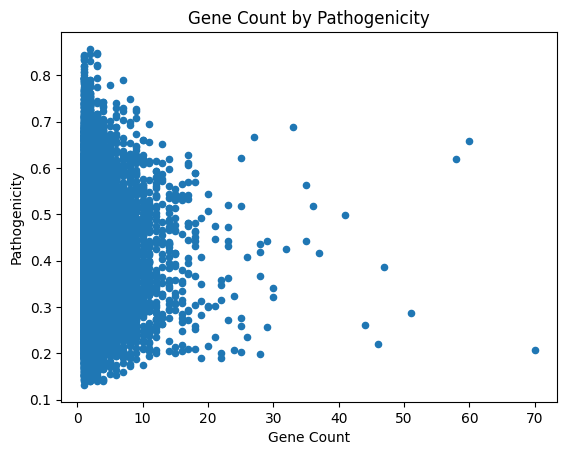

In [ ]:
en_miss_with_path_counts.plot( x='Gene_Count', y='mean_am_pathogenicity',  kind='scatter', marker='o')

plt.title('Gene Count by Pathogenicity')
plt.xlabel('Gene Count')
plt.ylabel('Pathogenicity')
plt.show()


This didn't show a correlation, but that could be because some patients might just have lots of mutations in one gene, but it isn't frequent across patients. As such, we tried limiting the definition of Gene_Count to be across patients.

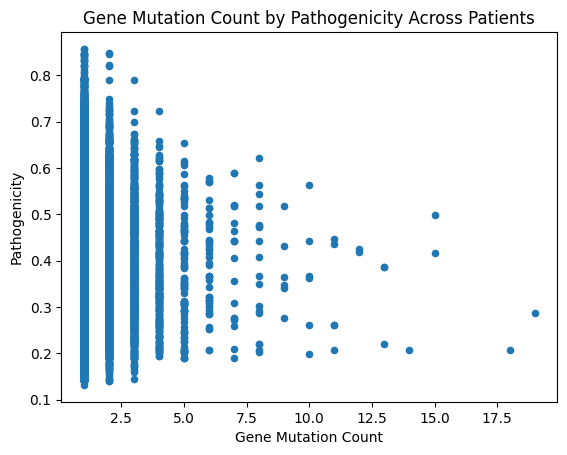

,Gene,mean_am_pathogenicity,Patient_ID,Gene_Count
25280,SYNE1,0.287823,C3L-00586,19
15770,MUC16,0.206472,C3L-00586,18
8667,FAT3,0.415481,C3L-00586,15
5835,CSMD3,0.499169,C3L-00586,15
15781,MUC16,0.206472,C3N-00328,14
...,...,...,...,...
11021,HID1,0.576786,C3L-00586,1
11020,HID1,0.576786,C3L-00361,1
11019,HIC2,0.456230,C3N-01520,1
11018,HIC2,0.456230,C3L-00006,1


In [ ]:
en_miss_with_path_counts_by_patient= en_miss_with_path.groupby(["Gene","mean_am_pathogenicity","Patient_ID"]).agg(Gene_Count=('Gene', 'count')).reset_index()

en_miss_with_path_counts_by_patient.plot( x='Gene_Count', y='mean_am_pathogenicity',  kind='scatter', marker='o')

plt.title('Gene Mutation Count by Pathogenicity Across Patients')
plt.xlabel('Gene Mutation Count')
plt.ylabel('Pathogenicity')
plt.show()
en_miss_with_path_counts_by_patient.sort_values("Gene_Count", ascending=False)

As seen above, the graph didn't show a correlation between Gene Count (frequency of mutation in the CPTAC dataset) and pathogenicty. To rule out that this was just an artifact of Endometrial cancer, we repeated the steps above on Breast cancer.

In [ ]:
#There doesn't seem to be a great correlation, even when counting by patients. What if we do a different cancer?
cptac.download('brca')
brca = cptac.Brca()

brca_som = brca.get_somatic_mutation()
brca_miss = brca_som[brca_som['Mutation']=="Missense_Mutation"]
brca_miss["Patient_ID"] = brca_miss.index
brca_miss

<ipython-input-18-828357ee89c0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brca_miss["Patient_ID"] = brca_miss.index


Name,Gene,Mutation,Location,Patient_ID
Patient_ID,,,,
CPT000814,ABCG8,Missense_Mutation,p.V660L,CPT000814
CPT000814,ACTRT1,Missense_Mutation,p.S138F,CPT000814
CPT000814,ADA,Missense_Mutation,p.A73T,CPT000814
CPT000814,C12orf71,Missense_Mutation,p.E36D,CPT000814
CPT000814,CBS,Missense_Mutation,p.S387N,CPT000814
...,...,...,...,...
X22BR006,MUC5B,Missense_Mutation,p.S3013A,X22BR006
X22BR006,PIK3CA,Missense_Mutation,p.H1047R,X22BR006
X22BR006,SEMA4G,Missense_Mutation,p.A767D,X22BR006


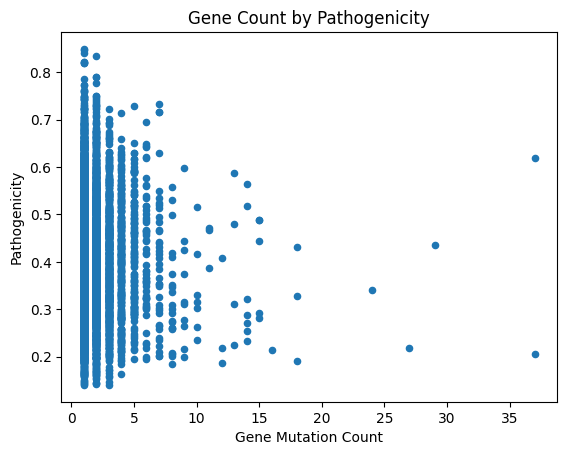

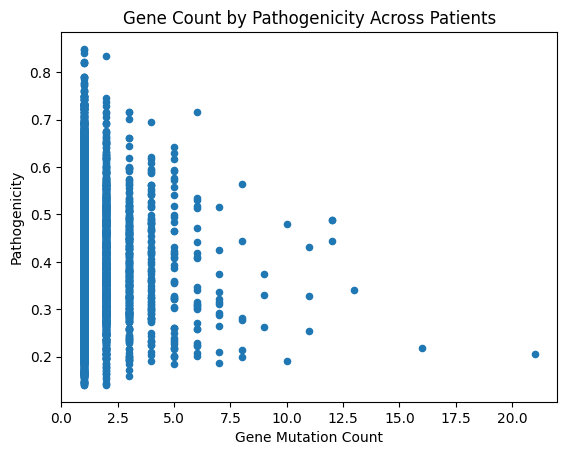

In [ ]:
brca_miss_with_path = brca_miss.merge(gene_pathogenicity_hg38,how='inner')
brca_miss_with_path_counts= brca_miss_with_path.groupby(["Gene","mean_am_pathogenicity"]).agg(Gene_Count=('Gene', 'count')).reset_index()

brca_miss_with_path_counts.plot( x='Gene_Count', y='mean_am_pathogenicity',  kind='scatter', marker='o')

plt.title('Gene Count by Pathogenicity')
plt.xlabel('Gene Mutation Count')
plt.ylabel('Pathogenicity')
plt.show()


brca_miss_with_path_counts_by_patient= brca_miss_with_path.groupby(["Gene","mean_am_pathogenicity","Patient_ID"]).agg(Gene_Count=('Gene', 'count')).reset_index()

brca_miss_with_path_counts_by_patient.plot( x='Gene_Count', y='mean_am_pathogenicity',  kind='scatter', marker='o')

plt.title('Gene Count by Pathogenicity Across Patients')
plt.xlabel('Gene Mutation Count')
plt.ylabel('Pathogenicity')
plt.show()


##Pathogenicity by Codon (Breast)

At a gene level, neither Breast cancer or Endometrial cancer seemed to show a correlation between mutation frequency and gene-level pathogenicity. However, we were worried about a Simpson's Paradox -- the risk of a pattern being hidden or different when data is analyzed in bulk as opposed to sub-populations. In our case, that meant that gene level pathogenicity might hide data about specific amino acid pathogenicity scores.

We hypothesized that the correlation might be stronger if we analyzed specific amino acids' pathogenicity as it relates to mutation frequency.


In [ ]:
#This adds a pathogenicity column to a CPTAC somatic mutation dataset.
def add_pathogenicity(row):
  gene= row["Gene"]
  mutation = row["Location"]
  if type(mutation) !=str or type(gene) !=str:
    return np.nan
  missense = mutation.lstrip("p.")
  mutation = gene+"_"+missense
  try:
    path = hg38.loc[(mutation), "am_pathogenicity"]
    return float(path)

  except:
    return float(np.nan)

In [ ]:
brca_miss["Pathogenicity"] = brca_miss.apply(add_pathogenicity, axis=1)

<ipython-input-21-03b8d7a23c99>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brca_miss["Pathogenicity"] = brca_miss.apply(add_pathogenicity, axis=1)


In [ ]:
brca_miss.dropna(inplace=True)
brca_miss

<ipython-input-22-afdaf8c66173>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brca_miss.dropna(inplace=True)


Name,Gene,Mutation,Location,Patient_ID,Pathogenicity
Patient_ID,,,,,
CPT000814,ABCG8,Missense_Mutation,p.V660L,CPT000814,0.0781
CPT000814,ACTRT1,Missense_Mutation,p.S138F,CPT000814,0.2784
CPT000814,ADA,Missense_Mutation,p.A73T,CPT000814,0.2155
CPT000814,C12orf71,Missense_Mutation,p.E36D,CPT000814,0.1817
CPT000814,CBS,Missense_Mutation,p.S387N,CPT000814,0.1446
...,...,...,...,...,...
X22BR006,DCLK3,Missense_Mutation,p.F572I,X22BR006,0.8321
X22BR006,MUC5B,Missense_Mutation,p.S3013A,X22BR006,0.1006
X22BR006,PIK3CA,Missense_Mutation,p.H1047R,X22BR006,0.5381


In [ ]:
#Pull out the actual missense mutation location into a new column
def get_missense_pos(row):
  loc = row["Location"]
  mutation_pos = re.findall(r"p\.\w(\d+)\w", loc)
  if len(mutation_pos)!=1:
    print(mutation_pos)
    return np.nan
  else:
    return mutation_pos[0]

brca_miss["Missense_Pos"] = brca_miss.apply(get_missense_pos, axis=1)

<ipython-input-23-13e2174d8c0b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brca_miss["Missense_Pos"] = brca_miss.apply(get_missense_pos, axis=1)


In [ ]:
#Grouped by the missense position, and not the specific mutation so that we could have higher counts.
brca_miss_counts= brca_miss.groupby(["Gene","Missense_Pos","Pathogenicity"]).agg(Missense_Count=('Gene', 'count')).reset_index()
brca_miss_counts.sort_values(by='Missense_Count',ascending=False)

,Gene,Missense_Pos,Pathogenicity,Missense_Count
7366,PIK3CA,1047,0.5381,15
7371,PIK3CA,345,0.9973,4
7375,PIK3CA,545,0.9878,4
426,AKT1,17,0.9977,4
10120,TP53,193,0.9982,3
...,...,...,...,...
3790,GDI1,12,0.9942,1
3791,GDPD3,282,0.1201,1
3792,GEM,269,0.9138,1
3793,GEMIN5,27,0.1403,1


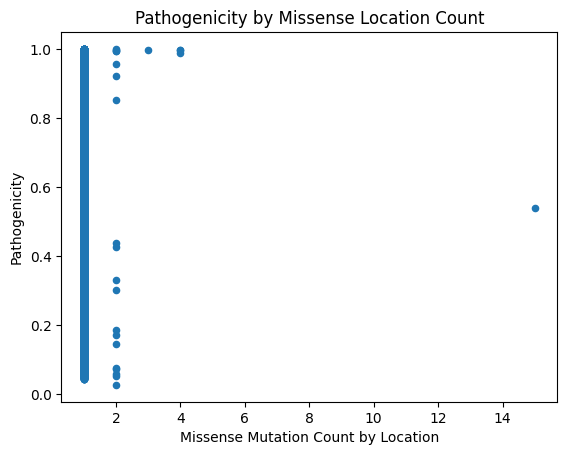

In [ ]:
brca_miss_counts.plot( x='Missense_Count', y='Pathogenicity',  kind='scatter', marker='o')

plt.title('Pathogenicity by Missense Location Count')
plt.xlabel('Missense Mutation Count by Location')
plt.ylabel('Pathogenicity')
plt.show()

These graphs ended up being the same, but we wanted to test if the results were different if we looked at the specific mutations instead of just their location.

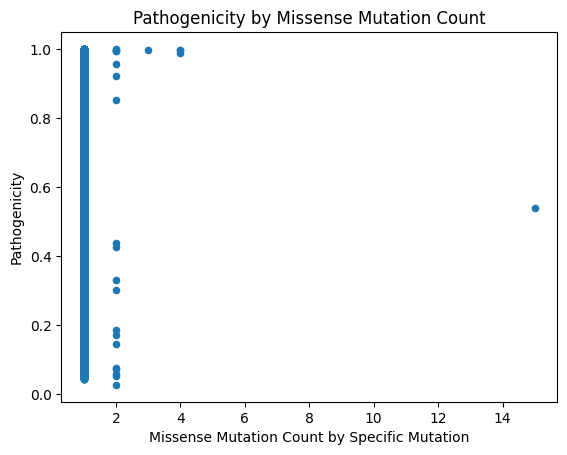

,Gene,Location,Pathogenicity,Missense_Count
7373,PIK3CA,p.H1047R,0.5381,15
7368,PIK3CA,p.E545K,0.9878,4
426,AKT1,p.E17K,0.9977,4
7375,PIK3CA,p.N345K,0.9973,4
10119,TP53,p.H193R,0.9982,3
...,...,...,...,...
3790,GDI1,p.T12N,0.9942,1
3791,GDPD3,p.E282Q,0.1201,1
3792,GEM,p.F269L,0.9138,1
3793,GEMIN5,p.L27F,0.1403,1


In [ ]:
brca_miss_counts_loc= brca_miss.groupby(["Gene","Location","Pathogenicity"]).agg(Missense_Count=('Gene', 'count')).reset_index()

brca_miss_counts_loc.plot( x='Missense_Count', y='Pathogenicity',  kind='scatter', marker='o')

plt.title('Pathogenicity by Missense Mutation Count')
plt.xlabel('Missense Mutation Count by Specific Mutation')
plt.ylabel('Pathogenicity')
plt.show()

brca_miss_counts_loc.sort_values(by="Missense_Count", ascending=False)

##Uniprot

Since we didn't see a correlation between pathogenicity and mutation frequency in the CPTAC dataset, we wanted to just rule out that the AlphaMissense model is awful (unlikely, but possible!)
To do this, we assumed that mutations in known domains or binding regions would be, on average, more pathogenic than the gene as a whole.

To test this, we analyzed the 20 most commonly mutated genes in BRCA against Uniprot data.

### Get a list of the top 20 most mutated gene in BRCA

In [ ]:
brca_miss_no_index= brca_miss.reset_index(drop=True)

In [ ]:
#most frequently mutated genes. (This does not take into account patients)
#Possibly MUC16 and others are just high because one patient has lots of mutations
brca_miss_by_gene= brca_miss_no_index.groupby(["Gene"]).agg(Gene_Count=('Gene', 'count')).reset_index()
brca_miss_by_gene.sort_values(by="Gene_Count",ascending=False)

,Gene,Gene_Count
3449,MUC16,37
4191,PIK3CA,37
5767,TP53,29
1989,FLG,27
4069,PCLO,24
...,...,...
2663,IREB2,1
2661,IRAK1,1
2656,IQGAP2,1
2655,IQGAP1,1


In [ ]:
#And this does take patients into account. Seperating by patients might give us a better idea of the
#most commonly mutated genes across a population, so we went with the top 20 genes from this dataset.
brca_miss_by_gene_and_patient = brca_miss_no_index.groupby('Gene')['Patient_ID'].nunique().reset_index()
brca_miss_by_gene_and_patient.sort_values(by="Patient_ID", ascending=False)

,Gene,Patient_ID
4191,PIK3CA,34
5767,TP53,27
3449,MUC16,16
11,ABCA13,11
1989,FLG,11
...,...,...
2556,IGHV2OR16-5,1
2553,IGHG2,1
2551,IGHA1,1
2550,IGFBP6,1


In [ ]:
top_genes = brca_miss_by_gene_and_patient.sort_values(by="Patient_ID", ascending=False).head(20)["Gene"].tolist()
top_genes_lowercase = [gene.lower() for gene in top_genes]

### Query Uniprot for binding/domain locations

First, we will look at "binding" locations according to Uniprot, then we will look at "Domains" from Uniprot. Unclear exactly what the difference between these two is, but some proteins have binding sites while others have domains.

In [ ]:
#Get the accession number from UniProt to map the gene names to the API
url = 'https://rest.uniprot.org/uniprotkb/search'


gene_accession_dic = {}
for gene in top_genes_lowercase:
  params = {
      'format': 'list',
      'query': f'gene_exact:{gene} AND organism_id:9606 AND reviewed:true'
  }

  response = requests.get(url, params=params)
  accession = response.text.rstrip().split()
  if len(accession)==0:
    print(gene)
  else:
    gene_accession_dic[gene] = accession[0]

gene_accession_dic

{'pik3ca': 'P42336',
 'tp53': 'P04637',
 'muc16': 'Q8WXI7',
 'abca13': 'Q86UQ4',
 'flg': 'P11362',
 'ahnak': 'Q09666',
 'ryr1': 'P21817',
 'muc17': 'Q685J3',
 'spta1': 'P02549',
 'muc5b': 'Q9HC84',
 'syne1': 'Q8NF91',
 'hmcn1': 'Q96RW7',
 'hydin': 'Q4G0P3',
 'plec': 'Q15149',
 'ank2': 'Q01484',
 'ryr2': 'Q92736',
 'lrp2': 'P98164',
 'frg1': 'Q14331',
 'frem2': 'Q5SZK8',
 'map3k1': 'Q13233'}

In [ ]:
#Create a nested dictionary of the binding domain JSON for each gene
gene_json_dic_binding = {}
for k,v in gene_accession_dic.items():
  binding_response = requests.get('https://www.ebi.ac.uk/proteins/api/features/' + v + '?types=BINDING')
  json_variant_dictionary = json.loads(binding_response.text)
  gene_json_dic_binding[k] = json_variant_dictionary

In [ ]:
#Pull out the binding locations for each gene in the list
gene_binding_areas = {}
for gene, dic in gene_json_dic_binding.items():
  gene_binding_areas[gene] = []
  if 'features' not in dic.keys():
    print(gene)
  else:
    for i in dic["features"]:
      gene_binding_areas[gene].append((int(i["begin"]),int(i["end"])))

gene_binding_areas

#Some are empty, because they use "DOMAINS" in UniProt, not "BINDING". We will test those seperately

{'pik3ca': [],
 'tp53': [(176, 176), (179, 179), (238, 238), (242, 242)],
 'muc16': [],
 'abca13': [(3875, 3882), (4754, 4761)],
 'flg': [(484, 490),
  (514, 514),
  (562, 564),
  (568, 568),
  (627, 627),
  (641, 641)],
 'ahnak': [],
 'ryr1': [(3892, 3892),
  (3966, 3966),
  (4210, 4214),
  (4717, 4717),
  (4955, 4960),
  (4980, 4986),
  (5002, 5002)],
 'muc17': [],
 'spta1': [(2284, 2284),
  (2286, 2286),
  (2288, 2288),
  (2290, 2290),
  (2295, 2295),
  (2327, 2327),
  (2333, 2333),
  (2338, 2338)],
 'muc5b': [(194, 194), (311, 311), (358, 358)],
 'syne1': [],
 'hmcn1': [],
 'hydin': [],
 'plec': [],
 'ank2': [],
 'ryr2': [],
 'lrp2': [(1126, 1126),
  (1129, 1129),
  (1131, 1131),
  (1133, 1133),
  (1139, 1139),
  (1140, 1140),
  (1208, 1208),
  (1210, 1210),
  (1212, 1212),
  (1218, 1218),
  (1219, 1219)],
 'frg1': [],
 'frem2': [],
 'map3k1': [(1249, 1257), (1272, 1272)]}

In [ ]:
#This isn't pretty, but the fastest way (we tried many!) to query the sorted dataframe
#for whether a location had a mutation in the AlphaMissense dataset was to loop through each
#letter and check if it was there.
#There is room to optimize this, but it works relatively fast for binding/domain sites.
letters = list(string.ascii_uppercase)

def get_average_pathogenicity_of_loc(gene,loc):
  alphaMissenseGene = gene.upper()
  result= []
  for letter in letters:
    for letter1 in letters:
      try:
        path = hg38.loc[(f'{gene}_{letter}{str(loc)}{letter1}'),"am_pathogenicity"]
        result.append(path)
      except:
        pass

  return sum(result)/len(result)


In [ ]:
#Run the function above for each mutation location then average those across all
#the binding amino acids in the gene.
average_binding_path_dic = {}

for gene,amino_acids in gene_binding_areas.items():

  result_list = []
  for amino_acid_pair in amino_acids:
    for i in range(amino_acid_pair[0],amino_acid_pair[1]+1):
      average_path_of_amino_acid= get_average_pathogenicity_of_loc(gene.upper(), i)
      result_list.append(average_path_of_amino_acid)

  if len(result_list)!=0:
    average_binding_path_dic[gene.upper()] = sum(result_list)/len(result_list)

average_binding_path_dic

{'TP53': 0.9986434523809524,
 'ABCA13': 0.5836921130952382,
 'FLG': 0.1706595068027211,
 'RYR1': 0.8774704978354978,
 'SPTA1': 0.34441845238095237,
 'MUC5B': 0.4144563492063493,
 'LRP2': 0.7913047619047618,
 'MAP3K1': 0.9165775}

In [ ]:
#Create a dictionary of the gene-level pathogenicities
gene_path_dic = {}
for gene, path in average_binding_path_dic.items():
  gene_level_path = gene_pathogenicity_hg38[gene_pathogenicity_hg38["Gene"]==gene]['mean_am_pathogenicity'].tolist()
  gene_path_dic[gene] =gene_level_path[0]

gene_path_dic

{'TP53': 0.4358922780824322,
 'ABCA13': 0.2340271667186667,
 'FLG': 0.2173804334506737,
 'RYR1': 0.5879805421639823,
 'SPTA1': 0.2718532272687464,
 'MUC5B': 0.2823509430910333,
 'LRP2': 0.4077923078211009,
 'MAP3K1': 0.4676756780790086}

Is the average pathogenicity of binding amino acids different than the gene-level pathogenicity?

In [ ]:
#Paired t-test, need to check if distributions are normal.
average_binding_path = list(average_binding_path_dic.values())
gene_path = list(gene_path_dic.values())

print(stats.shapiro(average_binding_path)) #Normal!
print(stats.shapiro(gene_path)) #Normal!

ShapiroResult(statistic=0.9291442036628723, pvalue=0.5083185434341431)
ShapiroResult(statistic=0.9175484776496887, pvalue=0.41028863191604614)


In [ ]:
#Thus, we are OK to perform a paired t-test!
stats.ttest_rel(gene_path,average_binding_path)

TtestResult(statistic=-3.7724270688090695, pvalue=0.006960810221488647, df=7)

The p-value is very small, so we can say that we have found significance!

In [ ]:
#Prepare the dictionaries to be graphed
boxplot_df = pd.DataFrame({'Pathogenicity':average_binding_path})
boxplot_df["Type"] = "Binding"

boxplot_df_1 = pd.DataFrame({'Pathogenicity':gene_path})
boxplot_df_1["Type"] = "Average"

combined = pd.concat([boxplot_df,boxplot_df_1])
combined

,Pathogenicity,Type
0,0.998643,Binding
1,0.583692,Binding
2,0.170660,Binding
3,0.877470,Binding
4,0.344418,Binding
5,0.414456,Binding
6,0.791305,Binding
7,0.916578,Binding
0,0.435892,Average
1,0.234027,Average


<Axes: xlabel='Type', ylabel='Pathogenicity'>

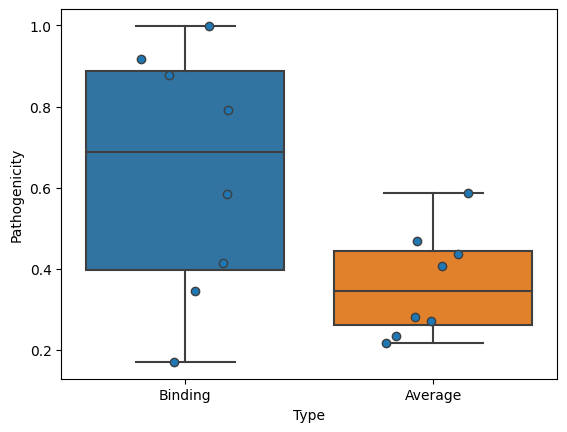

In [ ]:
sns.boxplot(x="Type", y="Pathogenicity", data=combined)
sns.stripplot(x="Type", y="Pathogenicity", data=combined, dodge=True, jitter=0.2, linewidth=1, s=6)

### Analyze Domains
Similar to the code above, but instead of pulling "?types=BINDING" from Uniprot, we look at "?types=DOMAIN" this time.

In [ ]:
#Dictionary of genes with their domain sites pulled from UniProt using the same gene_accession_dic
#as before.
gene_json_dic_domain = {}
for k,v in gene_accession_dic.items():
  domain_response = requests.get('https://www.ebi.ac.uk/proteins/api/features/' + v + '?types=DOMAIN')
  json_domain_dictionary = json.loads(domain_response.text)
  gene_json_dic_domain[k] = json_domain_dictionary

gene_json_dic_domain

{'pik3ca': {'accession': 'P42336',
  'entryName': 'PK3CA_HUMAN',
  'sequence': 'MPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIKHELFKEARKYPLHQLLQDESSYIFVSVTQEAEREEFFDETRRLCDLRLFQPFLKVIEPVGNREEKILNREIGFAIGMPVCEFDMVKDPEVQDFRRNILNVCKEAVDLRDLNSPHSRAMYVYPPNVESSPELPKHIYNKLDKGQIIVVIWVIVSPNNDKQKYTLKINHDCVPEQVIAEAIRKKTRSMLLSSEQLKLCVLEYQGKYILKVCGCDEYFLEKYPLSQYKYIRSCIMLGRMPNLMLMAKESLYSQLPMDCFTMPSYSRRISTATPYMNGETSTKSLWVINSALRIKILCATYVNVNIRDIDKIYVRTGIYHGGEPLCDNVNTQRVPCSNPRWNEWLNYDIYIPDLPRAARLCLSICSVKGRKGAKEEHCPLAWGNINLFDYTDTLVSGKMALNLWPVPHGLEDLLNPIGVTGSNPNKETPCLELEFDWFSSVVKFPDMSVIEEHANWSVSREAGFSYSHAGLSNRLARDNELRENDKEQLKAISTRDPLSEITEQEKDFLWSHRHYCVTIPEILPKLLLSVKWNSRDEVAQMYCLVKDWPPIKPEQAMELLDCNYPDPMVRGFAVRCLEKYLTDDKLSQYLIQLVQVLKYEQYLDNLLVRFLLKKALTNQRIGHFFFWHLKSEMHNKTVSQRFGLLLESYCRACGMYLKHLNRQVEAMEKLINLTDILKQEKKDETQKVQMKFLVEQMRRPDFMDALQGFLSPLNPAHQLGNLRLEECRIMSSAKRPLWLNWENPDIMSELLFQNNEIIFKNGDDLRQDMLTLQIIRIMENIWQNQGLDLRMLPYGCLSIGDCVGLIEVVRNSHTIMQIQCKGGLKGALQFNSHTLHQWLKDKNKGEIYDAAIDLFTRSCAGYCVATFILGIGDRHNSN

In [ ]:
gene_domain_areas = {}
for gene, dic in gene_json_dic_domain.items():
  gene_domain_areas[gene] = []
  if 'features' not in dic.keys():
    print(gene)
  else:
    for i in dic["features"]:
      gene_domain_areas[gene].append((int(i["begin"]),int(i["end"])))

gene_domain_areas

{'pik3ca': [(16, 105), (187, 289), (330, 487), (517, 694), (765, 1051)],
 'tp53': [],
 'muc16': [(12072, 12193),
  (12228, 12349),
  (12386, 12507),
  (12542, 12663),
  (12697, 12818),
  (12853, 12974),
  (13009, 13130),
  (13165, 13286),
  (13321, 13442),
  (13477, 13598),
  (13633, 13754),
  (13789, 13909),
  (13922, 14043),
  (14073, 14193),
  (14198, 14309),
  (14319, 14438)],
 'abca13': [(3842, 4074), (4718, 4956)],
 'flg': [(25, 119), (158, 246), (255, 357), (478, 767)],
 'ahnak': [(9, 90)],
 'ryr1': [(97, 152),
  (159, 204),
  (210, 264),
  (270, 327),
  (335, 392),
  (581, 797),
  (1013, 1208),
  (1356, 1570),
  (4074, 4102)],
 'muc17': [(4131, 4170), (4184, 4291)],
 'spta1': [(977, 1036), (2271, 2306), (2314, 2349), (2352, 2386)],
 'muc5b': [(75, 245),
  (329, 385),
  (423, 598),
  (695, 752),
  (805, 855),
  (855, 927),
  (893, 1062),
  (5073, 5261),
  (5412, 5484),
  (5521, 5587),
  (5653, 5742)],
 'syne1': [(27, 134), (178, 283), (8738, 8797)],
 'hmcn1': [(41, 216),
  (431,

As you can see, domains have many more amino acids involved than binding. Because of this, the following block of code may take 6-7 minutes to run. Sorry!

In [ ]:
average_domain_path_dic = {}

for gene,amino_acids in gene_domain_areas.items():

  result_list = []
  for amino_acid_pair in amino_acids:
    for i in range(amino_acid_pair[0], amino_acid_pair[1]+1):
      average_path_of_amino_acid= get_average_pathogenicity_of_loc(gene.upper(), i)
      result_list.append(average_path_of_amino_acid)

  if len(result_list)!=0:
    average_domain_path_dic[gene.upper()] = sum(result_list)/len(result_list)

average_domain_path_dic

{'PIK3CA': 0.6592756474673203,
 'MUC16': 0.33032815420905187,
 'ABCA13': 0.3660125600282486,
 'FLG': 0.24162606833374578,
 'AHNAK': 0.6016482462253194,
 'RYR1': 0.5730397040450588,
 'MUC17': 0.45354288288288297,
 'SPTA1': 0.31916673082406627,
 'MUC5B': 0.3725398480243161,
 'SYNE1': 0.5484706473757388,
 'HMCN1': 0.3155823265237138,
 'PLEC': 0.6707071650675194,
 'ANK2': 0.6835581318681324,
 'RYR2': 0.5717825446592282,
 'LRP2': 0.4447719771112863,
 'FREM2': 0.36101447953374893,
 'MAP3K1': 0.7686318009308988}

In [ ]:
gene_domain_path_dic = {}
for gene, path in average_domain_path_dic.items():
  gene_level_path = gene_pathogenicity_hg38[gene_pathogenicity_hg38["Gene"]==gene]['mean_am_pathogenicity'].tolist()
  gene_domain_path_dic[gene] =gene_level_path[0]

gene_domain_path_dic

{'PIK3CA': 0.6197308598201599,
 'MUC16': 0.206471503651203,
 'ABCA13': 0.2340271667186667,
 'FLG': 0.2173804334506737,
 'AHNAK': 0.2928730225160395,
 'RYR1': 0.5879805421639823,
 'MUC17': 0.1901893547311776,
 'SPTA1': 0.2718532272687464,
 'MUC5B': 0.2823509430910333,
 'SYNE1': 0.2878227724113937,
 'HMCN1': 0.3222889165020401,
 'PLEC': 0.3954197685968937,
 'ANK2': 0.4306631216989812,
 'RYR2': 0.5644057839971459,
 'LRP2': 0.4077923078211009,
 'FREM2': 0.3520601959899259,
 'MAP3K1': 0.4676756780790086}

In [ ]:
#Paired t-test, need to check if distributions are normal.
average_domain_path = list(average_domain_path_dic.values())
gene_domain_path = list(gene_domain_path_dic.values())

print(stats.shapiro(average_domain_path))
print(stats.shapiro(gene_domain_path))

ShapiroResult(statistic=0.9406288862228394, pvalue=0.32571810483932495)
ShapiroResult(statistic=0.9197149872779846, pvalue=0.14604410529136658)


In [ ]:
stats.ttest_rel(gene_domain_path,average_domain_path)

TtestResult(statistic=-4.277703754612293, pvalue=0.000576861971078738, df=16)

We also see significance here, with a p-value very small!

In [ ]:
boxplot_df = pd.DataFrame({'Pathogenicity':average_domain_path})
boxplot_df["Type"] = "Domain"

boxplot_df_1 = pd.DataFrame({'Pathogenicity':gene_domain_path})
boxplot_df_1["Type"] = "Average"

combined = pd.concat([boxplot_df,boxplot_df_1])
combined

,Pathogenicity,Type
0,0.659276,Domain
1,0.330328,Domain
2,0.366013,Domain
3,0.241626,Domain
4,0.601648,Domain
5,0.573040,Domain
6,0.453543,Domain
7,0.319167,Domain
8,0.372540,Domain
9,0.548471,Domain


<Axes: xlabel='Type', ylabel='Pathogenicity'>

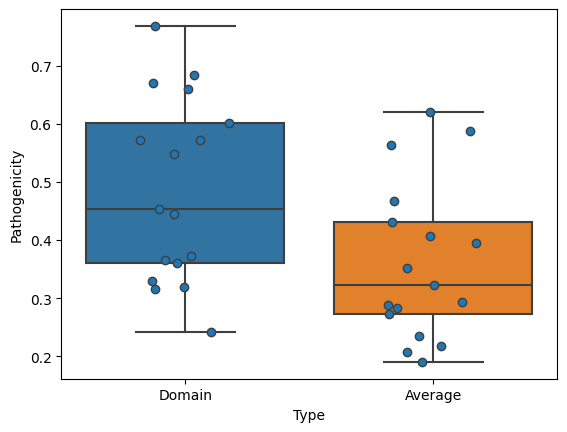

In [ ]:
sns.boxplot(x="Type", y="Pathogenicity", data=combined)
sns.stripplot(x="Type", y="Pathogenicity", data=combined, dodge=True, jitter=0.2, linewidth=1, s=6)

## Domains/Binding Overrepresented in CPTAC

It looks like AlphaMissense did a good job of predicting that Domains/Binding sites would be more pathogenic than the average amino acid in a gene. From that, along with the robust tests performed in the original AlphaMissense paper, we are assuming that AlphaMissense works as a general pathogenicity predictor.

To further this, we wanted to verify that 'domains' and 'binding sites' are mutated more frequently in CPTAC, because if they weren't, that could explain the lack of correlation.

To find this, we needed to find the length of each protein, length of the domains, and whether those were more frequently mutated that would be expected by random chance (Chi Square goodness of fit)

In [ ]:
#Protein lengths for each gene
gene_length_dic_domain = {}
for gene, dic in gene_json_dic_domain.items():
  gene_length_dic_domain[gene] = 0
  if 'sequence' not in dic.keys():
    print(gene)
  else:
    gene_length_dic_domain[gene] = len(dic['sequence'])

gene_length_dic_domain

{'pik3ca': 1068,
 'tp53': 393,
 'muc16': 14507,
 'abca13': 5058,
 'flg': 822,
 'ahnak': 5890,
 'ryr1': 5038,
 'muc17': 4493,
 'spta1': 2419,
 'muc5b': 5762,
 'syne1': 8797,
 'hmcn1': 5635,
 'hydin': 5121,
 'plec': 4684,
 'ank2': 3957,
 'ryr2': 4967,
 'lrp2': 4655,
 'frg1': 258,
 'frem2': 3169,
 'map3k1': 1512}

In [ ]:
#Proportion domains
domain_proportions = {}
for gene,amino_acids in gene_domain_areas.items():

  result_list = []
  for amino_acid_pair in amino_acids:
    for i in range(amino_acid_pair[0], amino_acid_pair[1]+1):
      result_list.append(i)
  if len(result_list) !=0:
    domain_proportions[gene] = len(result_list)/gene_length_dic_domain[gene]

domain_proportions

{'pik3ca': 0.7640449438202247,
 'muc16': 0.13359068036120494,
 'abca13': 0.09331751680506128,
 'flg': 0.7019464720194647,
 'ahnak': 0.013921901528013583,
 'ryr1': 0.18459706232631998,
 'muc17': 0.03294012908969508,
 'spta1': 0.06903679206283589,
 'muc5b': 0.20392224921902116,
 'syne1': 0.031146981925656472,
 'hmcn1': 0.8748890860692103,
 'plec': 0.05721605465414176,
 'ank2': 0.1281273692191054,
 'ryr2': 0.18300785182202536,
 'lrp2': 0.34994629430719654,
 'frem2': 0.16629851688229724,
 'map3k1': 0.17592592592592593}

In [ ]:
#Proportion domains
domain_proportions = {}
for gene,amino_acids in gene_domain_areas.items():

  result_list = []
  for amino_acid_pair in amino_acids:
    for i in range(amino_acid_pair[0], amino_acid_pair[1]+1):
      result_list.append(i)
  if len(result_list) !=0:
    domain_proportions[gene] = len(result_list)/gene_length_dic_domain[gene]

domain_proportions

{'pik3ca': 0.7640449438202247,
 'muc16': 0.13359068036120494,
 'abca13': 0.09331751680506128,
 'flg': 0.7019464720194647,
 'ahnak': 0.013921901528013583,
 'ryr1': 0.18459706232631998,
 'muc17': 0.03294012908969508,
 'spta1': 0.06903679206283589,
 'muc5b': 0.20392224921902116,
 'syne1': 0.031146981925656472,
 'hmcn1': 0.8748890860692103,
 'plec': 0.05721605465414176,
 'ank2': 0.1281273692191054,
 'ryr2': 0.18300785182202536,
 'lrp2': 0.34994629430719654,
 'frem2': 0.16629851688229724,
 'map3k1': 0.17592592592592593}

In [ ]:
#Domain
brca_miss_domain_genes = brca_miss[brca_miss["Gene"].isin(average_domain_path_dic.keys())]

In [ ]:
brca_gene_mut_counts = {}
brca_gene_domain_counts = {}

for gene,amino_acids in gene_domain_areas.items():

  amino_acid_locs = []
  for amino_acid_pair in amino_acids:
    for i in range(amino_acid_pair[0], amino_acid_pair[1]+1):
      amino_acid_locs.append(str(i))

  if len(amino_acid_locs)!=0:
    brca_gene_mut_counts[gene] = len(brca_miss_domain_genes[(brca_miss_domain_genes["Gene"]==gene.upper())])
    brca_gene_domain_counts[gene] = len(brca_miss_domain_genes[(brca_miss_domain_genes["Gene"]==gene.upper()) & (brca_miss_domain_genes["Missense_Pos"].isin(amino_acid_locs))])


for k in brca_gene_mut_counts.keys():
  print(brca_gene_mut_counts[k], brca_gene_domain_counts[k])


37 34
37 8
14 0
27 5
15 1
13 2
18 0
14 2
15 2
14 1
14 11
7 0
18 2
14 1
12 7
8 1
7 3


In [ ]:
expected_domain_muts = {}
for gene,count in brca_gene_mut_counts.items():
  expected_domain_muts[gene] = count * domain_proportions[gene]


for k in expected_domain_muts.keys():
  print(k, expected_domain_muts[k], brca_gene_domain_counts[k])


pik3ca 28.269662921348313 34
muc16 4.942855173364583 8
abca13 1.306445235270858 0
flg 18.952554744525546 5
ahnak 0.20882852292020374 1
ryr1 2.39976181024216 2
muc17 0.5929223236145115 0
spta1 0.9665150888797025 2
muc5b 3.0588337382853172 2
syne1 0.43605774695919064 1
hmcn1 12.248447204968945 11
plec 0.4005123825789923 0
ank2 2.306292645943897 2
ryr2 2.5621099255083553 1
lrp2 4.199355531686359 7
frem2 1.330388135058378 1
map3k1 1.2314814814814814 3


In [ ]:
f_obs=list(brca_gene_domain_counts.values())
f_exp=list(expected_domain_muts.values())

f_exp_adj = [sum(f_obs)/sum(f_exp) * i for i in f_exp]

stats.chisquare(f_obs=f_obs, f_exp = f_exp_adj)

Power_divergenceResult(statistic=27.925580478452915, pvalue=0.0322728501173881)

From the Chi Square analysis, we can see that there is a significant difference, but the graph below shows that the difference is minuscule.

<Axes: xlabel='Type', ylabel='Count'>

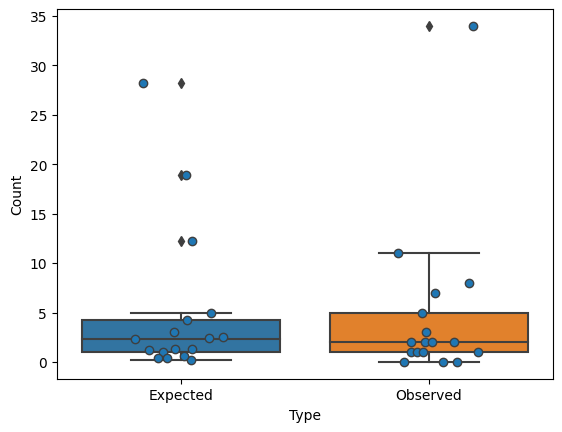

In [ ]:
boxplot_df = pd.DataFrame({'Count':f_exp})
boxplot_df["Type"] = "Expected"

boxplot_df_1 = pd.DataFrame({'Count':f_obs})
boxplot_df_1["Type"] = "Observed"

combined = pd.concat([boxplot_df,boxplot_df_1])

sns.boxplot(x="Type", y="Count", data=combined)
sns.stripplot(x="Type", y="Count", data=combined, dodge=True, jitter=0.2, linewidth=1, s=6)

We can't  perform the same analysis for the binding areas, since there are so few amino acids in the binding areas (about 5-10 per protein) that the expected values are less than 1 for most of the proteins, so we can't do a robust statistical analysis. Nonetheless, it looks like there aren't many mutations in binding sites anyway.

In [ ]:
binding_proportions = {}
for gene,amino_acids in gene_binding_areas.items():

  result_list = []
  for amino_acid_pair in amino_acids:
    for i in range(amino_acid_pair[0], amino_acid_pair[1]+1):
      result_list.append(i)
  if len(result_list) !=0:
    binding_proportions[gene] = len(result_list)/gene_length_dic_domain[gene]

brca_gene_binding_counts = {}
brca_gene_mut_counts = {}
for gene,amino_acids in gene_binding_areas.items():

  amino_acid_locs = []
  for amino_acid_pair in amino_acids:
    for i in range(amino_acid_pair[0], amino_acid_pair[1]+1):
      amino_acid_locs.append(str(i))

  if len(amino_acid_locs)!=0:
    brca_gene_mut_counts[gene] = len(brca_miss_domain_genes[(brca_miss_domain_genes["Gene"]==gene.upper())])
    brca_gene_binding_counts[gene] = len(brca_miss_domain_genes[(brca_miss_domain_genes["Gene"]==gene.upper()) & (brca_miss_domain_genes["Missense_Pos"].isin(amino_acid_locs))])


for k in brca_gene_mut_counts.keys():
  print(brca_gene_mut_counts[k], brca_gene_binding_counts[k])


0 0
14 0
27 1
13 0
14 0
15 0
12 0
7 0


## Ethnicity Bias in Alpha Missense

From the previous data, we determined that AlphaMissense predicts most pathogenic amino acids to be in binding domains, as expected.
Potentially, the lack of correlation between pathogenicity and mutation frequency could be cause AlphaMissense is biased towards certain ethnicities.  In this, we look at how ethnicities are represented in the Alpha Missense data. Specifically, does Alpha Missense do better at predicting pathogenicity of mutations for certain ethnicities?

In [ ]:
brca_ethnicities = brca.get_clinical()["Ethnicity"]
brca_grouped = brca.get_clinical()['Ethnicity'].value_counts()
brca_ethnicity_list = brca_ethnicities.dropna()
brca_ethnicity_list = brca_ethnicity_list.tolist()
brca_grouped

white                        78
asian                        19
black.or.african.american    14
hispanic.or.latino            4
Name: Ethnicity, dtype: int64

Since the BRCA database only has four hispanic individuals, we will drop this category from our upcoming analysis.

In [ ]:
brca_mutations_and_ethnicities = pd.merge(brca_miss, brca_ethnicities, left_index=True, right_index=True)
brca_white_mutations = brca_mutations_and_ethnicities.loc[brca_mutations_and_ethnicities["Ethnicity"] == "white"]
brca_black_mutations = brca_mutations_and_ethnicities.loc[brca_mutations_and_ethnicities["Ethnicity"] == "black.or.african.american"]
brca_asian_mutations = brca_mutations_and_ethnicities.loc[brca_mutations_and_ethnicities["Ethnicity"] == "asian"]

brca_miss_counts_white= brca_white_mutations.groupby(["Gene"]).agg(Gene_Count=('Gene', 'count'), Path_Average=("Pathogenicity", "mean")).reset_index()
brca_miss_counts_white.sort_values(by='Gene_Count',ascending=False, inplace=True)

brca_miss_counts_black= brca_black_mutations.groupby(["Gene"]).agg(Gene_Count=('Gene', 'count'), Path_Average=("Pathogenicity", "mean")).reset_index()
brca_miss_counts_black.sort_values(by='Gene_Count',ascending=False, inplace=True)

brca_miss_counts_asian= brca_asian_mutations.groupby(["Gene"]).agg(Gene_Count=('Gene', 'count'), Path_Average=("Pathogenicity", "mean")).reset_index()
brca_miss_counts_asian.sort_values(by='Gene_Count',ascending=False, inplace=True)

brca_miss_counts_asian

,Gene,Gene_Count,Path_Average
608,PIK3CA,8,0.625812
499,MUC16,6,0.156150
45,ANK2,5,0.264640
144,CEP250,5,0.263120
839,TP53,4,0.988225
...,...,...,...
47,ANKLE1,1,0.234400
369,HSPA8,1,0.082100
370,HSPG2,1,0.473300
371,HTR1B,1,0.061100


In [ ]:
white_mut_and_alpha_paths = pd.merge(brca_miss_counts_white, gene_pathogenicity_hg38, left_on="Gene", right_on="Gene")
black_mut_and_alpha_paths = pd.merge(brca_miss_counts_black, gene_pathogenicity_hg38, left_on="Gene", right_on="Gene")
asian_mut_and_alpha_paths = pd.merge(brca_miss_counts_asian, gene_pathogenicity_hg38, left_on="Gene", right_on="Gene")

white_mut_and_alpha_paths

,Gene,Gene_Count,Path_Average,transcript_id,mean_am_pathogenicity
0,MUC16,28,0.152618,ENST00000397910.8,0.206472
1,PIK3CA,25,0.732724,ENST00000263967.4,0.619731
2,PCLO,23,0.471209,ENST00000333891.14,0.339897
3,FLG,22,0.168609,ENST00000368799.1,0.217380
4,TP53,20,0.955620,ENST00000445888.6,0.435892
...,...,...,...,...,...
5724,MYOCD,1,0.070700,ENST00000343344.8,0.308585
5725,MYOF,1,0.857300,ENST00000359263.9,0.475026
5726,COLEC12,1,0.083400,ENST00000400256.5,0.383636
5727,COL9A2,1,0.147600,ENST00000372748.8,0.332037


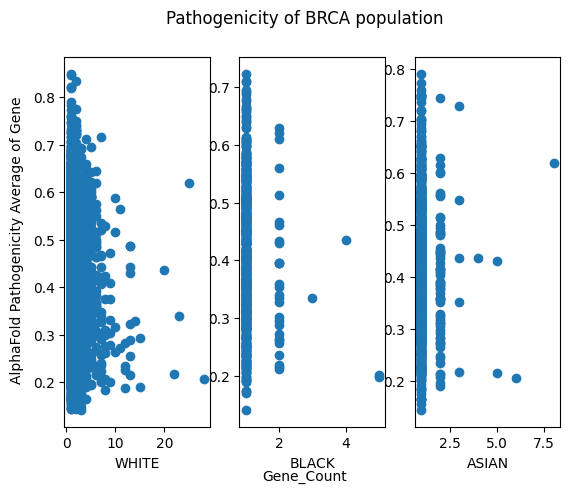

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Pathogenicity of BRCA population')
fig.text(0.5, 0.0, 'Gene_Count', ha='center')
fig.text(0.04, 0.5, 'AlphaFold Pathogenicity Average of Gene', va='center', rotation='vertical')
ax1.scatter(white_mut_and_alpha_paths['Gene_Count'], white_mut_and_alpha_paths['mean_am_pathogenicity'], marker='o')
ax2.scatter(black_mut_and_alpha_paths['Gene_Count'], black_mut_and_alpha_paths['mean_am_pathogenicity'], marker='o')
ax3.scatter(asian_mut_and_alpha_paths['Gene_Count'], asian_mut_and_alpha_paths['mean_am_pathogenicity'], marker='o')

ax1.set_xlabel("WHITE")
ax2.set_xlabel("BLACK")
ax3.set_xlabel("ASIAN")

plt.show()

What genes are known to be highly mutated in ASIAN individuals with breast cancer? According to Nature Journal (https://www.nature.com/articles/s41467-020-20173-5#:~:text=The%20most%20frequently%20mutated%20genes,%25)%20and%20NF1%20(3.1%25)), these are the top 5 highest mutated genes: TP53, PIK3CA, GATA3, MAP3K1, and PTEN.

The highly mutated genes for BLACK breast cancer patients are the following (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9811638/): TP53, ARID1B, BRCA1, BRCA2, and RAD51B.

The highly mutated genes for WHITE breast cancer patients are the following (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4478970/): BRCA1, BRCA2, PTEN, TP53, CDH1, and STK11.

And finally, the top mutated genes for HISPANIC breast cancer patients are the following (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5160045/#:~:text=Of%20the%20patients%20with%20breast,1%2C%20BARD1%20%3D%201): BRCA1, BRCA2, PTEN, TP53, and CDH1.

In [ ]:
#We need to update our add_pathogenicity function to take input from the gene_pathogenicity_hg38 dataframe and to not look for specific mutation loci
def add_pathogenicity_for_genes(row):
  gene= row["Gene"]
  if type(gene)!=str:
    return np.nan
  try:
    path = gene_pathogenicity_hg38.loc[gene_pathogenicity_hg38['Gene'] == gene]['mean_am_pathogenicity'].tolist()[0]
    return path

  except:
    return np.nan

In [ ]:
asian_highly_mutated_genes = pd.DataFrame({"Gene":['TP53', 'PIK3CA', 'GATA3', 'MAP3K1', 'PTEN']})
asian_highly_mutated_genes['Pathogenicity'] = asian_highly_mutated_genes.apply(add_pathogenicity_for_genes, axis=1)

black_highly_mutated_genes = pd.DataFrame({"Gene":['TP53', 'ARID1B', 'BRCA1', 'BRCA2', 'RAD51B']})
black_highly_mutated_genes['Pathogenicity'] = black_highly_mutated_genes.apply(add_pathogenicity_for_genes, axis=1)

white_highly_mutated_genes = pd.DataFrame({"Gene":['BRCA1', 'BRCA2', 'PTEN', 'CDH1', 'STK11']})
white_highly_mutated_genes['Pathogenicity'] = white_highly_mutated_genes.apply(add_pathogenicity_for_genes, axis=1)

hispanic_highly_mutated_genes = pd.DataFrame({"Gene":['BRCA1', 'BRCA2', 'PTEN', 'TP53', 'CDH1']})
hispanic_highly_mutated_genes['Pathogenicity'] = hispanic_highly_mutated_genes.apply(add_pathogenicity_for_genes, axis=1)

In [ ]:
print(sum(white_highly_mutated_genes['Pathogenicity'])/len(white_highly_mutated_genes['Pathogenicity']))
print(sum(black_highly_mutated_genes['Pathogenicity'])/len(black_highly_mutated_genes['Pathogenicity']))
print(sum(asian_highly_mutated_genes['Pathogenicity'])/len(asian_highly_mutated_genes['Pathogenicity']))
print(sum(hispanic_highly_mutated_genes['Pathogenicity'])/len(hispanic_highly_mutated_genes['Pathogenicity']))

0.4125293501619506
0.3335080295160938
0.5295325050545767
0.3848294444579011


In [ ]:
from scipy.stats import shapiro

print(shapiro(white_highly_mutated_genes['Pathogenicity']))
print(shapiro(black_highly_mutated_genes['Pathogenicity']))
print(shapiro(asian_highly_mutated_genes['Pathogenicity']))
print(shapiro(hispanic_highly_mutated_genes['Pathogenicity']))

ShapiroResult(statistic=0.8939599990844727, pvalue=0.37740790843963623)
ShapiroResult(statistic=0.8672323822975159, pvalue=0.2553970515727997)
ShapiroResult(statistic=0.8274431824684143, pvalue=0.13309116661548615)
ShapiroResult(statistic=0.9006496071815491, pvalue=0.4134863018989563)


Since the data is normally distributed, we will go ahead with an ANOVA test.

In [ ]:
from scipy.stats import f_oneway

f_oneway(white_highly_mutated_genes['Pathogenicity'], black_highly_mutated_genes['Pathogenicity'], asian_highly_mutated_genes['Pathogenicity'], hispanic_highly_mutated_genes['Pathogenicity'])

F_onewayResult(statistic=1.2910286600985088, pvalue=0.31152535132955356)

The ANOVA test has a p-value higher than 0.05, so we cannot reject the null hypothesis that the pathogenicities for the different ethnicities are not related. However, we can look at a graph to get a visual representation of the data.

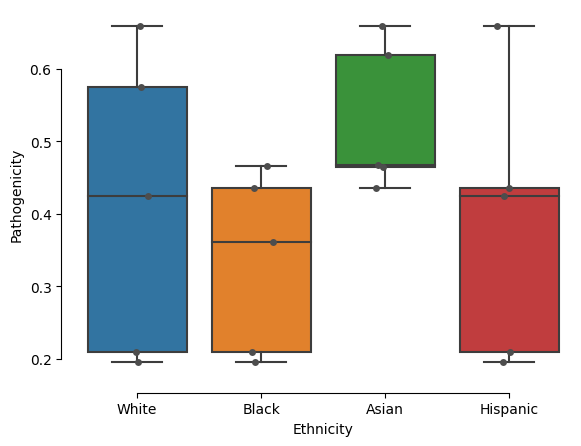

In [ ]:
white_highly_mutated_genes['Ethnicity'] = 'White'
black_highly_mutated_genes['Ethnicity'] = 'Black'
asian_highly_mutated_genes['Ethnicity'] = 'Asian'
hispanic_highly_mutated_genes['Ethnicity'] = 'Hispanic'

allEthnicityData = pd.concat([white_highly_mutated_genes, black_highly_mutated_genes, asian_highly_mutated_genes, hispanic_highly_mutated_genes])
allEthnicityData
sns.boxplot(x="Ethnicity", y="Pathogenicity",
             data=allEthnicityData)
sns.stripplot(data=allEthnicityData, x='Ethnicity', y='Pathogenicity', dodge=True, jitter=True, color='.3')

sns.despine(offset=10, trim=True)

From the ANOVA test and the graphs, it looks like the top 5 genes known to be mutated for breast cancer patients from these 4 different ethnicities appear to be generating relatively similar pathogenicity scores from Alpha Missense. Therefore, we cannot conclude from these data that Alpha Missense is biased towards any ethnicity.

##Pathogenicity and Cancer Stage
Another question was whether or not the number of pathogenic mutations would correspond to the severity of the disease. As a measure of severity, we decided to use cancer stage, since many other metrics (like cause or time of death) were not recorded consistently.

In [ ]:
enClinic = en.get_clinical()
brClinic = brca.get_clinical()

In [ ]:
enStatus = enClinic['tumor_Stage-Pathological']
#Breast cancer stages have a lot more subtypes so the regex lumps them together better
brStatus = brClinic['Stage'].str.replace('[ABC]', '', regex=True)
print(enStatus.value_counts())
print(brStatus.value_counts())

Stage I      68
Stage III    13
Stage II     10
Stage IV      4
Name: tumor_Stage-Pathological, dtype: int64
Stage II     70
Stage III    33
Stage I       4
Name: Stage, dtype: int64


In [ ]:
en_miss["am_pathogenicity"] = en_miss.apply(add_pathogenicity, axis=1)

<ipython-input-174-df43c510bf66>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_miss["am_pathogenicity"] = en_miss.apply(add_pathogenicity, axis=1)


In [ ]:
en_miss["Stage"] = enStatus
brca_miss["Stage"] = brStatus

en_miss_clean = en_miss.dropna().drop("Patient_ID", axis=1)
en_miss_clean["am_pathogenicity"] = en_miss_clean["am_pathogenicity"]
brca_miss_clean = brca_miss.dropna().drop("Patient_ID", axis=1)
brca_miss_clean["am_pathogenicity"] = brca_miss_clean["Pathogenicity"]
#brStatus = brca_miss_clean["Stage"].groupby("Patient_ID").first()

<ipython-input-176-dcf458d96c6d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_miss["Stage"] = enStatus
<ipython-input-176-dcf458d96c6d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brca_miss["Stage"] = brStatus


In [ ]:
en_miss_clean["pathogenic"] = pd.cut(x=en_miss_clean['am_pathogenicity'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1.0"])
brca_miss_clean["pathogenic"] = pd.cut(x=brca_miss_clean['am_pathogenicity'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1.0"])

en_miss_counts = en_miss_clean.reset_index().groupby("Patient_ID")["pathogenic"].value_counts().to_frame()
brca_miss_counts = brca_miss_clean.reset_index().groupby("Patient_ID")["pathogenic"].value_counts().to_frame()

en_miss_counts = en_miss_counts.rename(columns={'pathogenic': 'counts'}).reset_index().set_index("Patient_ID")
brca_miss_counts = brca_miss_counts.rename(columns={'pathogenic': 'counts'}).reset_index().set_index("Patient_ID")

en_miss_counts["Stage"] = enStatus
brca_miss_counts["Stage"] = brStatus

In [ ]:
print(en_miss_counts["Stage"].value_counts())
print(brca_miss_counts["Stage"].value_counts())

Stage I      340
Stage III     65
Stage II      50
Stage IV      20
Name: Stage, dtype: int64
Stage II     345
Stage III    165
Stage I       20
Name: Stage, dtype: int64


First, we will graph the endometrial data.

In [ ]:
countSet = en_miss_counts
#making sure we still have the right set of data
countSet["Stage"].value_counts()

Stage I      340
Stage III     65
Stage II      50
Stage IV      20
Name: Stage, dtype: int64

<Axes: xlabel='Stage', ylabel='counts'>

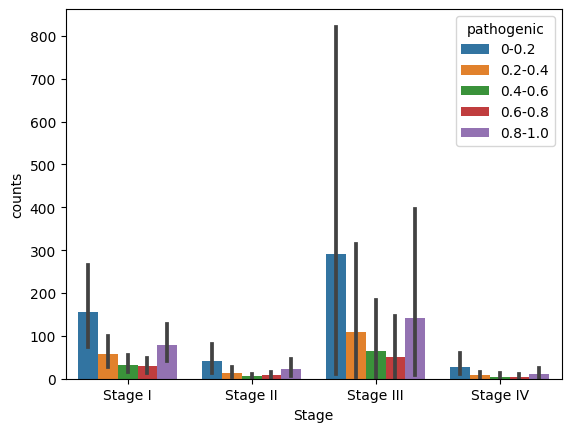

In [ ]:
sns.barplot(countSet.sort_values("Stage"), x="Stage", y="counts", hue="pathogenic" )

In [ ]:
p1 = countSet[countSet.pathogenic.isin(["0-0.2"])].groupby('Stage')['counts'].sum().reset_index()
p2 = countSet[countSet.pathogenic.isin(["0-0.2", "0.2-0.4"])].groupby('Stage')['counts'].sum().reset_index()
p3 = countSet[countSet.pathogenic.isin(["0-0.2", "0.2-0.4", "0.4-0.6"])].groupby('Stage')['counts'].sum().reset_index()
p4 = countSet[countSet.pathogenic.isin(["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8"])].groupby('Stage')['counts'].sum().reset_index()
p5 = countSet.groupby('Stage')['counts'].sum().reset_index()
p1['frequency'] = [i / j * 100 for i,j in zip(p1['counts'], p5['counts'])]
p2['frequency'] = [i / j * 100 for i,j in zip(p2['counts'], p5['counts'])]
p3['frequency'] = [i / j * 100 for i,j in zip(p3['counts'], p5['counts'])]
p4['frequency'] = [i / j * 100 for i,j in zip(p4['counts'], p5['counts'])]
p5['frequency'] = 100

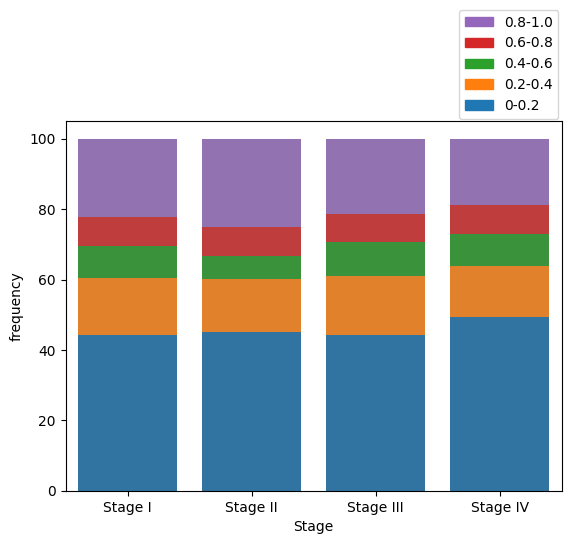

In [ ]:
bar1 = sns.barplot(x="Stage",  y="frequency", data=p5, color='tab:purple')
bar1 = sns.barplot(x="Stage",  y="frequency", data=p4, color='tab:red')
bar1 = sns.barplot(x="Stage",  y="frequency", data=p3, color='tab:green')
bar1 = sns.barplot(x="Stage",  y="frequency", data=p2, color='tab:orange')
bar1 = sns.barplot(x="Stage",  y="frequency", data=p1, color='tab:blue')

p1_bar = ptc.Patch(color='tab:purple', label='0.8-1.0')
p2_bar = ptc.Patch(color='tab:red', label='0.6-0.8')
p3_bar = ptc.Patch(color='tab:green', label='0.4-0.6')
p4_bar = ptc.Patch(color='tab:orange', label='0.2-0.4')
p5_bar = ptc.Patch(color='tab:blue', label='0-0.2')
plt.legend(handles=[p1_bar, p2_bar, p3_bar, p4_bar, p5_bar], bbox_to_anchor=(0.78,1.32), loc=2)
plt.show()

Now, we will graph the BRCA data.

In [ ]:
countSet = brca_miss_counts
#making sure that we still have the right set of data
countSet["Stage"].value_counts()

Stage II     345
Stage III    165
Stage I       20
Name: Stage, dtype: int64

<Axes: xlabel='Stage', ylabel='counts'>

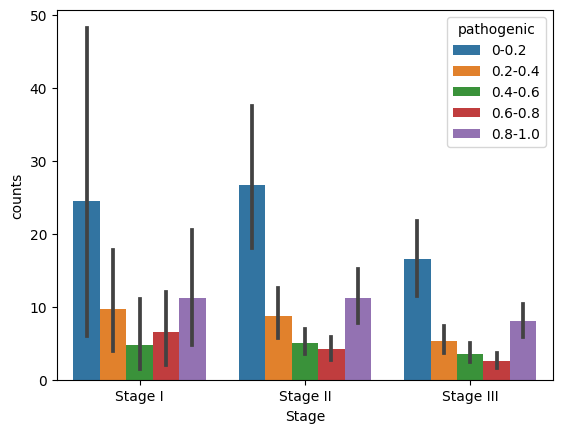

In [ ]:
sns.barplot(countSet.sort_values("Stage"), x="Stage", y="counts", hue="pathogenic" )

In [ ]:
p1 = countSet[countSet.pathogenic.isin(["0-0.2"])].groupby('Stage')['counts'].sum().reset_index()
p2 = countSet[countSet.pathogenic.isin(["0-0.2", "0.2-0.4"])].groupby('Stage')['counts'].sum().reset_index()
p3 = countSet[countSet.pathogenic.isin(["0-0.2", "0.2-0.4", "0.4-0.6"])].groupby('Stage')['counts'].sum().reset_index()
p4 = countSet[countSet.pathogenic.isin(["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8"])].groupby('Stage')['counts'].sum().reset_index()
p5 = countSet.groupby('Stage')['counts'].sum().reset_index()
p1['frequency'] = [i / j * 100 for i,j in zip(p1['counts'], p5['counts'])]
p2['frequency'] = [i / j * 100 for i,j in zip(p2['counts'], p5['counts'])]
p3['frequency'] = [i / j * 100 for i,j in zip(p3['counts'], p5['counts'])]
p4['frequency'] = [i / j * 100 for i,j in zip(p4['counts'], p5['counts'])]
p5['frequency'] = 100

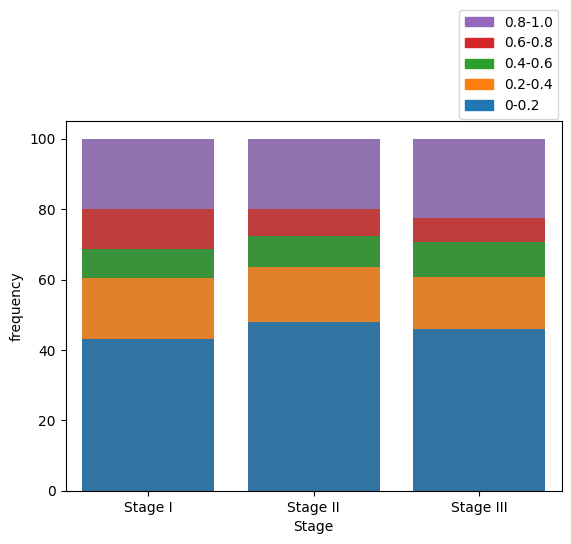

In [ ]:
bar1 = sns.barplot(x="Stage",  y="frequency", data=p5, color='tab:purple')
bar1 = sns.barplot(x="Stage",  y="frequency", data=p4, color='tab:red')
bar1 = sns.barplot(x="Stage",  y="frequency", data=p3, color='tab:green')
bar1 = sns.barplot(x="Stage",  y="frequency", data=p2, color='tab:orange')
bar1 = sns.barplot(x="Stage",  y="frequency", data=p1, color='tab:blue')

p1_bar = ptc.Patch(color='tab:purple', label='0.8-1.0')
p2_bar = ptc.Patch(color='tab:red', label='0.6-0.8')
p3_bar = ptc.Patch(color='tab:green', label='0.4-0.6')
p4_bar = ptc.Patch(color='tab:orange', label='0.2-0.4')
p5_bar = ptc.Patch(color='tab:blue', label='0-0.2')
plt.legend(handles=[p1_bar, p2_bar, p3_bar, p4_bar, p5_bar], bbox_to_anchor=(0.78,1.32), loc=2)
plt.show()

As we can see, both endometrial and breast cancer seem to have no significant connection between tumor stage and pathogenicity. There could be a few different explanations for this:



- Passenger mutations are picked up at a greater rate as pathogenic mutations accumulate and cause more errors in proofreading.
- Pathogenic mutations do not contribute any more to tumor progression than other mutations.

It is hard to say which one of these is true with this information. However, it is also interesting to note that the four different stages, while they might have had similar distributions of mutations had differnt mutation amounts at different stages, and they didn't always increase.
This is likely connected with the fact that stage I, II and III are associated with tumor size, and IV is associated with metastasis. So, a tumor could technically jump from I to IV without picking up many mutations if it got the "right" ones early on. This explains endometrial but not breast. It is really interesting that stage III tumors have less mutations in breast cancer, this could be a survivor's bias.

## Tumor Suppressors vs Oncogenes

In this portion of the project we will examine the pathogenicity of mutations found in known oncogenes and tumor suppressor genes (found in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6029450/figure/F3/). We would believe that due to the different natures of these genes, oncogenes will have more pathogenic mutations.

In [ ]:
#Found a list of tumor suppressor genes and oncogenes from Matt Bailey paper (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6029450/#SD4)
tumor_suppressor_genes = ["CASP8", "CDKN1A", "EP300", "CREBBP", "ARID1A", "ARID2", "KDM6A", "TP53", "NF1", "NF2", "CDH1", "APC", "PIK3R1"]
oncogenes = ["IDH1", "IDH2", "GNA11","GNAQ", "GNAS", "EGFR", "ERBB2", "ERBB4", "KRAS", "PIK3CA", "RHOA", "AKT1", "CTNNB1"]

In [ ]:
#Separating the tumor suppressor genes from the oncogenes
en_miss_tumor_suppressor = en_miss.loc[en_miss["Gene"].isin(tumor_suppressor_genes)]
brca_miss_tumor_suppressor = brca_miss.loc[brca_miss["Gene"].isin(tumor_suppressor_genes)]
en_miss_oncogene = en_miss.loc[en_miss["Gene"].isin(oncogenes)]
brca_miss_oncogene = brca_miss.loc[brca_miss["Gene"].isin(oncogenes)]

In [ ]:
#Labeling the entries and bringing the tables back together for creating graphs
en_miss_tumor_suppressor["Class"] = "Tumor Suppressor"
brca_miss_tumor_suppressor["Class"] = "Tumor Suppressor"

en_miss_oncogene["Class"] = "Oncogene"
brca_miss_oncogene["Class"] = "Oncogene"

en_miss_geneClass = pd.concat([en_miss_tumor_suppressor, en_miss_oncogene])
brca_miss_geneClass = pd.concat([brca_miss_tumor_suppressor, brca_miss_oncogene])

<ipython-input-191-daf1d7786ae8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_miss_tumor_suppressor["Class"] = "Tumor Suppressor"
<ipython-input-191-daf1d7786ae8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brca_miss_tumor_suppressor["Class"] = "Tumor Suppressor"
<ipython-input-191-daf1d7786ae8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

First, we will look at pathogenic mutations within tumor suppressor genes and oncogenes within the endometrial cohort:

<Axes: xlabel='Class', ylabel='am_pathogenicity'>

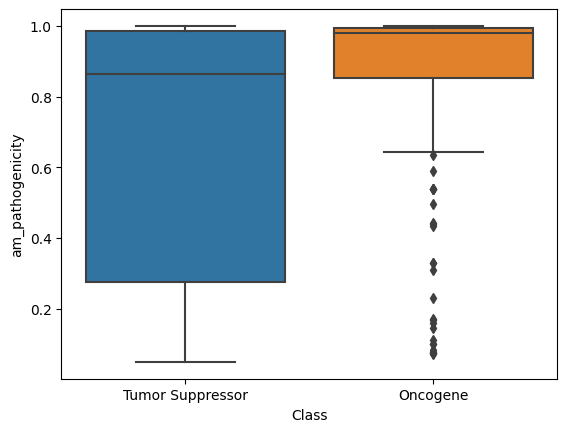

In [ ]:
sns.boxplot(en_miss_geneClass, x="Class", y="am_pathogenicity")

In [ ]:
#Mann-whitney u test because the distribution for Oncogenes looks very skewed
print(stats.mannwhitneyu(en_miss_tumor_suppressor["am_pathogenicity"].dropna(), en_miss_oncogene["am_pathogenicity"].dropna()))

MannwhitneyuResult(statistic=5681.0, pvalue=0.0001109489414952179)


Given the graphs, and the fact that the p-value is much smaller than .05, we can conclude that Oncogenes have significantly more pathogenic mutations than tumor suppressors.

Next, we will check to see if this holds true for breast cancers:

<Axes: xlabel='Class', ylabel='Pathogenicity'>

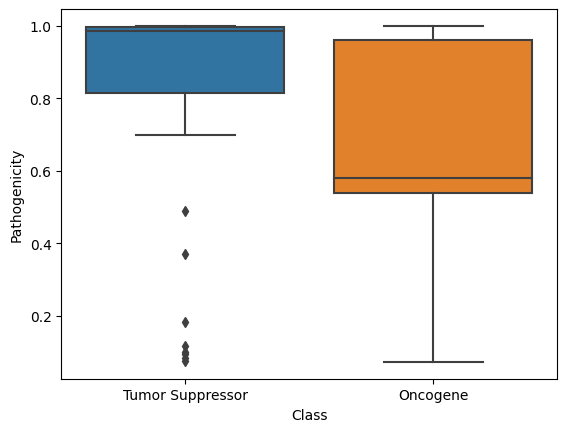

In [ ]:
sns.boxplot(brca_miss_geneClass, x="Class", y="Pathogenicity")

In [ ]:
#Mann-whitney test because the tumor suppressor set looks very skewed
print(stats.mannwhitneyu(brca_miss_tumor_suppressor["Pathogenicity"].dropna(), brca_miss_oncogene["Pathogenicity"].dropna()))

MannwhitneyuResult(statistic=1819.5, pvalue=0.0037240438134578603)


This difference is also significant. However, it is interesting to note that though Oncogenes were significantly more pathogenic in endometrial cancer, tumor suppressors were significantly more pathogenic in breast cancer. This likely ties into different cancer development pathways used in the formation of endometrial cancers vs breast cancers.